# For Your Key Only (FYKO)
- Author: Sai Mitra Jandhyala (mitra.js)

- Project Information: Executed as a part of Liverpool John Moores University's Thesis work in Machine Learning and Artificial Intelligence programme

- Project Description: Project is named as 'For Your Keys Only' (FYKO) because the aim of the project is to protect AES Keys from being exchanged over the network but yet enable Client and the Server to generate the same Keys using ANN models that take inputs which can be shared over the netowrk. This Research project uses an approach to make use of ANN's outputs to produce varying AES Keys to be used in Encryption and Decryption exchanged between Client-Server. Can be extended to peer-to-peer ecrypted communication. Brings in an added advantage of using a new AES Key in every interaction without having to exchange the key over the channel (HTTP/HTTPS based network)

- Notebook Information: Consists of Simple and Complex ANN Model creation, evaluation, experiments and finally a sample Python Client that can interact with a Flask Based App using similar code to generate and share ANN models securely (encrypted) with the Client.

- Setup Instructions: The Code uses dataset 'archive.zip' from Kaggle (https://www.kaggle.com/datasets/pavelbiz/random-hashes-md5-derived-from-random-strings). 'archive.zip' should be placed in the same location where the Notebook executes. Incase of Google Colab, 'archive.zip' should be present in the 'drive_path' variable

## Install required packages

In [1]:
!pip install pycryptodome
!pip install tensorflow
!pip install tensorflowjs
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install pydot

## import required packages

In [2]:
# for generating unique ids
import uuid 
# for md5 hashing
import hashlib

# UTC time
import time
# to convert binary to hex
import binascii

# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
from datetime import datetime
import time

#for unzipping dataset
import os
import zipfile

import secrets

#Data processing
import numpy as np
import pandas as pd
from numpy.linalg import norm

# for building ANN Model
import keras
from keras import layers
from keras import Sequential
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.initializers import RandomNormal, RandomUniform
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD

# for Tensorflow JS
import tensorflowjs as tfjs

# for plotting graphs
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import seaborn as sns

#crypto
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA

# base64 encoding to convert every encrypted string into ascii
import base64

from Crypto.Protocol.KDF import PBKDF2

from keras.models import load_model 

from tensorflow.python.ops.gen_array_ops import shape

# for testing python client
import requests
import json

#tf.random.set_seed(163)
secretsGenerator = secrets.SystemRandom()

## Graph theme

In [3]:
sns.set_style("whitegrid")

In [4]:
# to enable running it on Colab, set this variable to True and update the drive_path variable appropriately
is_google_drive = False

if is_google_drive:
  from google.colab import drive
  content_root = '/content/gdrive'
  drive.mount(content_root)
  drive_path = '<update your drive path where archive.zip is present>'
else:
  drive_path = '.'

## Utility functions

In [5]:
# alternate combination of elements from two array
def interleave_two_arrays(arr1, arr2):
  return [element for pair in zip(arr1, arr2) for element in pair]

In [6]:
# takes two binary strings and joins them into a single numerical array with 0s and 1s by interleaving
def join_binary_strings_as_array(binary_string1='',binary_string2='', one=1, zero=0):
  combined_arr = interleave_two_arrays(binary_string1, binary_string2)
  total_len = len(combined_arr)
  arr = [zero for i in range(0,total_len)]
  for i in range(0,total_len):
    if combined_arr[i] == '1':
      arr[i] = one

  return arr

In [7]:
# given a string, produces its md5 hash
def get_binary_md5(input_string=''):
  md5_hash = hashlib.md5(input_string.encode('utf-8'))
  hex_string = md5_hash.hexdigest()
  binary_md5 = bin(int(hex_string, 16))[2:].zfill(128)
  return binary_md5

In [8]:
# takes utc time in seconds, converts it into a string and returns its md5 hash
def get_utc_md5(utc_time=0):
  utc_time_str = str(utc_time)
  return get_binary_md5(utc_time_str)

In [9]:
# given a string, produces its md5 hash in hex
def get_md5_hex_string(input_string=''):
  md5_hash = hashlib.md5(input_string.encode('utf-8'))
  hex_string = md5_hash.hexdigest()
  return hex_string

In [10]:
# given a binary string, converts it into a hex string by padding leading 0s if required
def convert_binary_string_to_hex_string(binary_string=''):
  binary_string_len = len(binary_string)
  leading_zeros_to_pad = binary_string_len % 4
  binary_string = ''.join(['0' for i in range(0, leading_zeros_to_pad)]) + binary_string
  binary_string_len = len(binary_string)
  # take 4 byte strings and convert them to hex character
  hex_string = ''
  hex_string_len = binary_string_len // 4
  for i in range(0,hex_string_len):
    hex_string = hex_string + hex(int(binary_string[i*4:i*4+4], 2))[2:]
  return hex_string

In [11]:
HEX_TO_BINARY = {'0': '0000', '1': '0001', '2': '0010', '3': '0011', '4': '0100', '5': '0101', '6': '0110', '7': '0111', '8': '1000', '9': '1001', 'a': '1010', 'b': '1011', 'c': '1100', 'd': '1101', 'e': '1110', 'f': '1111'}

# converts a hex string to a binary array using HEX_TO_BINARY map
def convert_hex_string_to_binary_array(hex_string=''):
  binary_string = ''
  for digit in [*hex_string]:
      binary_string += HEX_TO_BINARY[digit]
  binary_string_arr =  [*binary_string]
  binary_arr = [1 if i == '1' else 0 for i in binary_string_arr]
  return binary_arr

In [12]:
# gets cosine similarity between two binary vectors
def get_cosine_similarity(binary_bit_arr1, binary_bit_arr2):
  a1 = np.array(binary_bit_arr1)
  a2 = np.array(binary_bit_arr2)
  cosine_similarity = np.dot(a1,a2)/(norm(a1)*norm(a2))
  return cosine_similarity

In [13]:
# gets l2 distance between two binary arrays
def get_l2_dist(binary_bit_arr1, binary_bit_arr2):
  a1 = np.array(binary_bit_arr1)
  a2 = np.array(binary_bit_arr2)
  return np.linalg.norm(a1 - a2)

In [14]:
# gets largest common subsequence length between two strings
def get_lcs(X, Y, m, n):
    if m == 0 or n == 0:
        return 0
    elif X[m-1] == Y[n-1]:
        return 1 + get_lcs(X, Y, m-1, n-1)
    else:
        return max(get_lcs(X, Y, m, n-1), get_lcs(X, Y, m-1, n))

In [15]:
# given two binary arrays, gets the longest common sequence between them
def get_longest_number_of_contiguous_bits(binary_bit_arr1, binary_bit_arr2):
  xor_arr = np.bitwise_xor(np.array(binary_bit_arr1), np.array(binary_bit_arr2))
  xor_arr_len = len(xor_arr)
  longest_seq_len_max = 0
  longest_seq_len = 0
  for i in xor_arr:
    if i == 0:
      longest_seq_len += 1
    else:
      if longest_seq_len > longest_seq_len_max:
        longest_seq_len_max = longest_seq_len
      longest_seq_len = 0

  if longest_seq_len > longest_seq_len_max:
    longest_seq_len_max = longest_seq_len

  return longest_seq_len_max

In [16]:
# main function for generating simple or complex ANN
def generate_ANN(use_complex_model=False, learning_rate=0.05):

  model = Sequential()
  model.add(Dense(256, activation='tanh', input_dim=256, kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
  # build extra layers for a complex model
  if use_complex_model == True:
    model.add(Dense(256, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(512, activation='tanh'))
    model.add(Dense(512, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Dense(1024, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(1024, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Dense(2048, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(2048, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(1024, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Dense(1024, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Dense(2048, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Dense(512, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Dense(512, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(256, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
  model.add(Dense(256, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
  model.add(Dense(256, activation='tanh', kernel_initializer='RandomNormal', bias_initializer='he_uniform'))
  
  model.compile(loss='mse', optimizer=SGD(learning_rate=learning_rate), metrics=['accuracy', 'mse'])

  return model

In [17]:
def do_quick_training(model, sample_size=10, training_epochs=10):
  inputs = []
  outputs = []
  for i in range(0, sample_size):
    random_string = str(uuid.uuid4())
    utc_time = int(time.time())
    input = np.array(join_binary_strings_as_array(get_binary_md5(random_string), get_utc_md5(utc_time)))
    inputs.append(input)
    y = np.array([random.random() for i in range(0,256)])
    outputs.append(y)
  inputs = np.array(inputs)
  outputs = np.array(outputs)
  model.fit(inputs, outputs, epochs=training_epochs, batch_size=sample_size, verbose=False)
  return model

In [18]:
# a method that takes an ANN model, a random string and utc time in seconds to produce an ANN
# returns aes key hex string, aes key bits, ann raw output, input string fed into the ANN
def generate_aes_key(input_model, random_string='', utc_time='0'):
  input_bits = join_binary_strings_as_array(get_binary_md5(random_string), get_utc_md5(utc_time))
  input_bits_str = ['1' if i==1 else '0' for i in input_bits]
  input_str = convert_binary_string_to_hex_string(''.join(input_bits_str))
  input_arr = np.array(input_bits)
  input_arr = tf.expand_dims(input_arr, axis=0)

  # predict with random weights
  y = input_model.predict(input_arr, verbose=False)
  
  # pick the first value as we are giving only one input
  # raw_ann_output would be floating point values emerging from the ANN
  raw_ann_output = np.array(y[0])
  # compute the mean value of the floating point values obtained in raw_ann_output
  mean_value = np.mean(raw_ann_output)
  aes_key_256 = ['1' if i > mean_value else '0' for i in raw_ann_output]
  aes_key_256_str = ''.join(aes_key_256)
  aes_key_256_bits = [1 if i > mean_value else 0 for i in raw_ann_output]
  
  return convert_binary_string_to_hex_string(aes_key_256_str), aes_key_256_bits, raw_ann_output, input_str

In [19]:
# gets the total number of differing bits between two binary arrays
def get_total_different_bits(binary_bit_arr1, binary_bit_arr2):
  a1 = np.array(binary_bit_arr1)
  a2 = np.array(binary_bit_arr2)
  bit_xor_arr = np.bitwise_xor(a1,a2)
  return sum(bit_xor_arr)

In [20]:
# function to extract dataset if its already not extracted
def extract_dataset(drive_path, zip_file_path='/archive.zip',data_folder_path='/data'):
    zip_archive_path = drive_path+zip_file_path
    data_folder_path = drive_path+data_folder_path
    if (os.path.exists(zip_archive_path)) and (os.path.exists(data_folder_path) == False):
        print(f'path exists: {zip_archive_path}')
        zipfd = zipfile.ZipFile(zip_archive_path,'r')
        print(f'extracting to folder: {data_folder_path}')
        zipfd.extractall(data_folder_path+'/')
        zipfd.close()
    elif os.path.exists(zip_archive_path) == False:
        print(f'path does not exist:'+ zip_archive_path)

## Model Saving functions

In [21]:
SIMPLE_MODEL_JSON_TEMPLATE = 'simple_model_json_{suffix}.json'
SIMPLE_MODEL_H5_TEMPLATE = 'simple_model_h5_{suffix}.h5'
SIMPLE_TFJS_MODEL_TEMPLATE = 'simple_tfjs_model_{suffix}'

COMPLEX_MODEL_JSON_TEMPLATE = 'complex_model_json_{suffix}.json'
COMPLEX_MODEL_H5_TEMPLATE = 'complex_model_h5_{suffix}.h5'
COMPLEX_TFJS_MODEL_TEMPLATE = 'complex_tfjs_model_{suffix}'

# Model Saving function
def save_model(model, is_complex=False,format='h5', suffix=str(time.time()), drive_path='.', model_folder_path='/models/'):
    if format == 'h5':
        if is_complex == True:
            model_file_name = drive_path + model_folder_path + COMPLEX_MODEL_H5_TEMPLATE.format(suffix=suffix)
        else:
            model_file_name = drive_path + model_folder_path + SIMPLE_MODEL_H5_TEMPLATE.format(suffix=suffix)
        model.save(model_file_name, overwrite=True)
        return model_file_name
    elif format == 'json':
        if is_complex == True:
            model_file_name = drive_path + model_folder_path + COMPLEX_MODEL_JSON_TEMPLATE.format(suffix=suffix)
        else:
            model_file_name = drive_path + model_folder_path + SIMPLE_MODEL_JSON_TEMPLATE.format(suffix=suffix)
        model_json = model.to_json()
        model_json_file = open(model_file_name, "w")
        model_json_file.write(model_json)
        return model_file_name
    elif format == 'tfjs':
        if is_complex == True:
            model_folder_name = drive_path + model_folder_path + COMPLEX_TFJS_MODEL_TEMPLATE.format(suffix=suffix)
        else:
            model_folder_name = drive_path + model_folder_path + SIMPLE_TFJS_MODEL_TEMPLATE.format(suffix=suffix)
        tfjs.converters.save_keras_model(model,model_folder_name)
        return model_folder_name
    return None

# Plotting functions for ANN inputs and outputs

In [22]:
# helper function that plots ANN output values
def plot_ann_values(aes_key_bits=[],ann_output=[], xlabel='', ylabel='', title=''):
  x = range(0, len(ann_output))
  
  fig = plt.figure(figsize=(21,6))
  
  if len(aes_key_bits) > 0:
    plt.plot(x,aes_key_bits, color='blue')
  
  if len(ann_output) > 0:
   plt.plot(x,ann_output, color='green')
   mean = np.mean(ann_output)
   mean_arr = [mean for i in range(0,len(ann_output))]
   plt.plot(x,mean_arr, color='darkred')

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show(fig)

In [23]:
# a generic function to plot an array
def plot_arr(arr=[],xlabel='', ylabel='', title=''):
  x = range(0, len(arr))
  
  fig = plt.figure(figsize=(21,6))
  
  if len(arr) > 0:
    plt.plot(x,arr, color='blue')
  
  mean = np.mean(arr)
  mean_arr = [mean for i in range(0,len(arr))]
  plt.plot(x,mean_arr, color='darkred')

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show(fig)

In [24]:
# function to plot ANN raw output values and the same converted into AES Key bits
def plot_random_outputs_of_ann(model, random_string=None, utc_time=0, show_raw_bits=False):
  if random_string == None:
    random_string = str(uuid.uuid4())
  if utc_time == 0:
    utc_time = int(time.time())
  combined_arr = join_binary_strings_as_array(get_binary_md5(random_string), get_utc_md5(utc_time))
  aes_key_str, raw_bits, raw_output,_ = generate_aes_key(model, random_string, utc_time)
  print(f'\nRandom string: {random_string}')
  print(f'UTC Time: {utc_time}')
  print(f'AES Key Produced: {aes_key_str}')
  title = f'ANN Raw output converted to AES Key binary bits \n\nRandom string={random_string}\nUTC Time={utc_time}\n AES Key Generated={aes_key_str}'
  if show_raw_bits == False:
    raw_bits = np.array([])
    ylabel = 'ANN Raw Output Values'
  else:
    ylabel = 'ANN Raw Output Values & AES Keys Binary bits'
  xlabel = "ANN Outputs index"
  plot_ann_values(raw_bits,raw_output, xlabel=xlabel, ylabel=ylabel,title=title)

## Illustration of AES Key Generation through ANN

In [25]:
model = generate_ANN()
random_string = str(uuid.uuid4())
utc_time = int(time.time())

print(f'random_string={random_string}, utc_time={utc_time}')
aes_key, aes_key_bits, raw_ann_output, input_str = generate_aes_key(model, random_string, utc_time)
print(f'aes_key={aes_key}')
print(f'aes_key_bits={aes_key_bits}')
print(f'input sring fed to ANN={input_str}')

random_string=c2fe500d-8db4-4342-934c-8084f0ee5772, utc_time=1683247429
aes_key=ced06668154e6b020a47c27e8fedb539e9a8020bd54e12be30515febe7adc381
aes_key_bits=[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
input sring fed to ANN=4e54e93868a9aaa568664e325f11010bd6110b92a3fe18401d

## ANN Model output values illustration through plots


Random string: 6kn^,HU
UTC Time: 1683247431
AES Key Produced: 2a68eb0662f0aab2197dcb1e10b03c67e379b8b15e86d61ad747858c98caa990


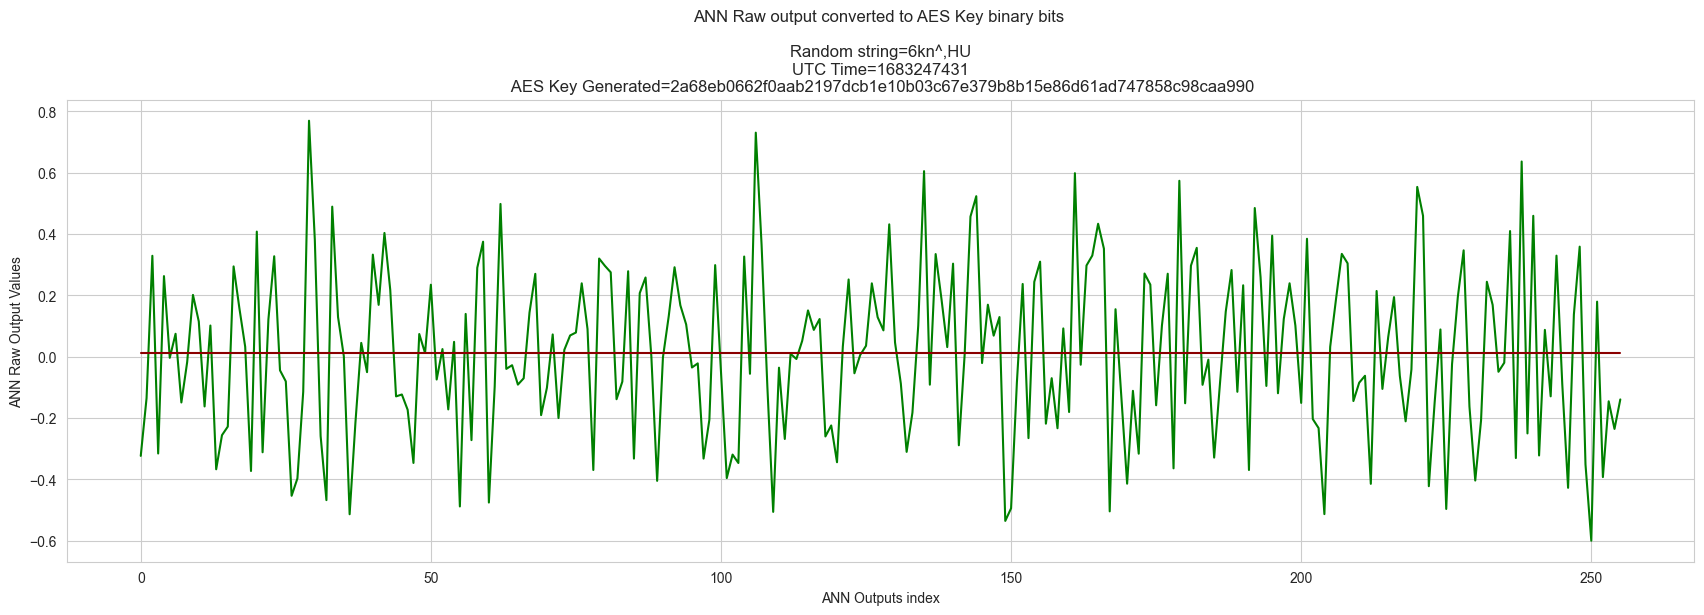


Random string: 6kn^,HU
UTC Time: 1683247432
AES Key Produced: 3a49cb4642e2e8b35b35f91831b09c64f7d1b1b15e06d71af743a698185a8992


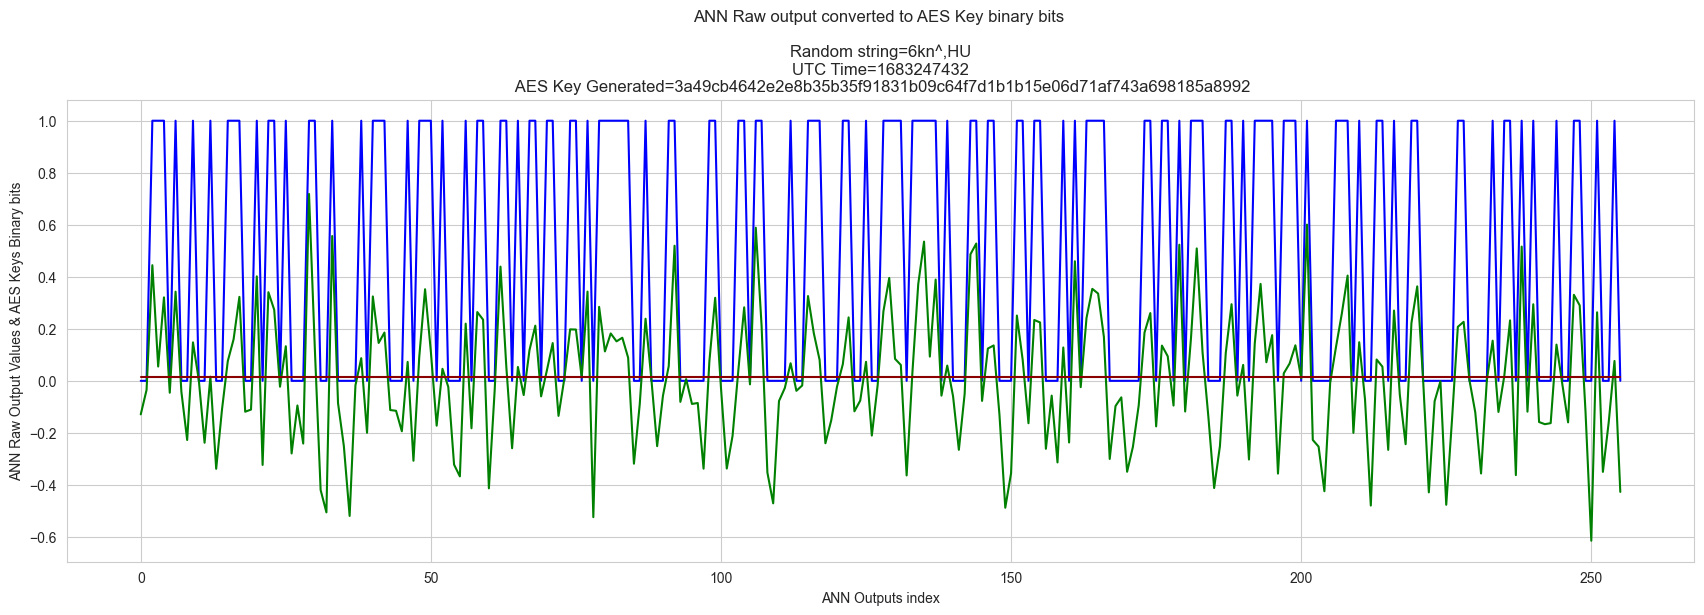

In [26]:
model = generate_ANN()
plot_random_outputs_of_ann(model, random_string='6kn^,HU',show_raw_bits=False)
plot_random_outputs_of_ann(model, random_string='6kn^,HU',show_raw_bits=True)

# Model Creation and Architecture Illustration

## Simple ANN Model architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
Total params: 197,376
Trainable params: 197,376
Non-trainable params: 0
_________________________________________________________________


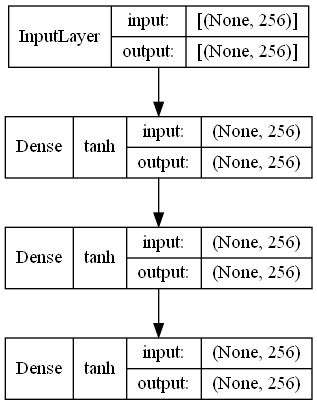

In [27]:
simple_model = generate_ANN(use_complex_model=False)
simple_model.summary()
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir='TB')

## Complex ANN Model Architecture

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1024)              525312    
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

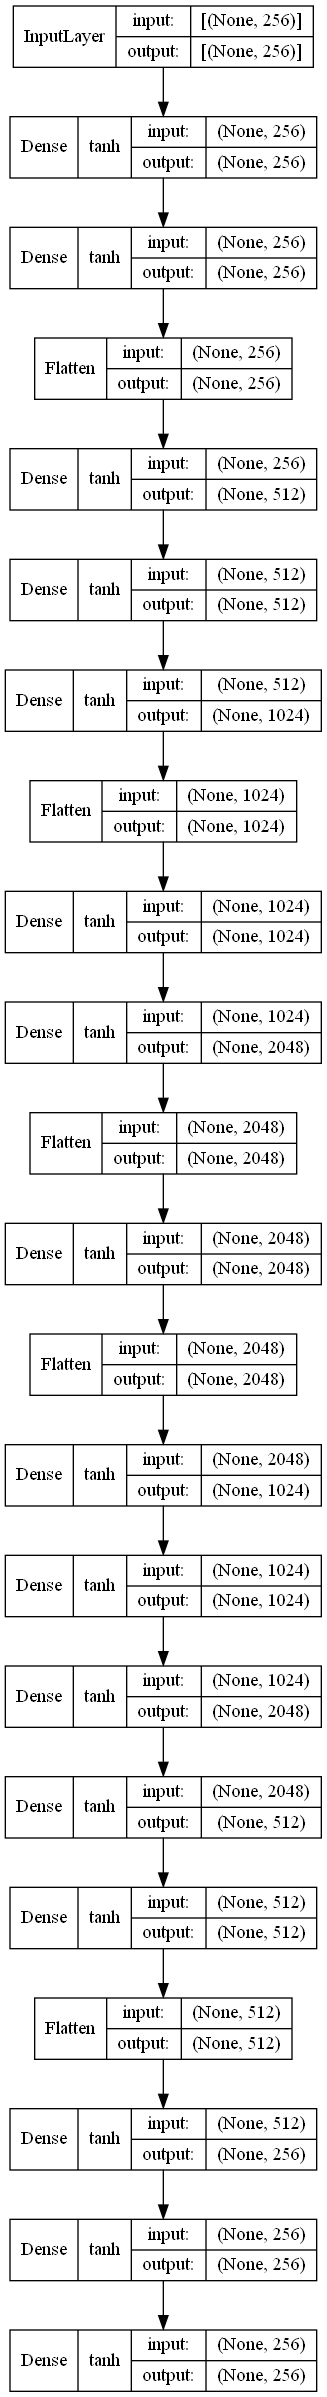

In [28]:
complex_model = generate_ANN(use_complex_model=True)
complex_model.summary()
plot_model(complex_model, show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir='TB')

# Experiments with ANN to illustrate its use in AES Key production

## Experiment 1: To check AES Key conflict with two ANN models taking same inputs
- Significance: Two different ANN models producing diverse keys implies that a Server can adopt ANN strategy to produce different ANNs for different client and be assured that their AES Keys are non-conflicting. This aids in the argument to promote ANNs are AES Key production units.

In [29]:
# tests two similar models but initialized with different random weights by feeding them
# with same inputs.
# Compares their keys to check if they are any common keys generated
# returns
#  the common set of keys which both the modules have produced
#  and an array of same keys produced with same inputs
def test_aes_key_conflict_between_two_anns(use_complex_model=False, iterations=100):
    generated1 = []
    generated2 = []
    same_aes_keys_generated_with_same_inputs = [] 
    repeat_count = 0
    
    if use_complex_model:
        model = generate_ANN(use_complex_model=True)
        model2 = generate_ANN(use_complex_model=True)
    else:
        model = generate_ANN(use_complex_model=False)
        model2 = generate_ANN(use_complex_model=False)
        
    for i in range(0,iterations):
      random_string = str(uuid.uuid4())
      utc_time = int(time.time())
      aes_key_str1,_,_,_= generate_aes_key(model, random_string, utc_time)
      aes_key_str2,_,_,_= generate_aes_key(model2, random_string, utc_time)
      if aes_key_str1 == aes_key_str2:
        print(f'FATAL Error: aes_key_str1={aes_key_str1} is same as aes_key_str2={aes_key_str2}')
        same_aes_keys_generated_with_same_inputs.append(aes_key_str1)
      generated1.append(aes_key_str1)
      generated2.append(aes_key_str2)

    generated1_set = set(generated1)
    generated2_set = set(generated2)
    return generated1_set.intersection(generated2_set),same_aes_keys_generated_with_same_inputs

In [30]:
def test_two_anns_for_aes_key_conflict(use_complex_model=False, iterations=100):
    common_set_of_keys, same_aes_keys_generated_with_same_inputs = test_aes_key_conflict_between_two_anns(use_complex_model=use_complex_model, iterations=100)
    model_type = 'simple'
    if use_complex_model:
        model_type = 'complex'
    message1 = f'Repeated aes key count with {model_type} models and {iterations} iterations: {len(common_set_of_keys)}'
    message2 = f'Same aes keys when two {model_type} ANNs fed with same input in {iterations} iterations: {same_aes_keys_generated_with_same_inputs}'
    print(message1)
    print(message2)

### Experiment 1.1
- Use two simple ANNs generated with different random weights
- Check for common keys
- Check if same aes key was produced by both ANNs when fed with same inputs

In [31]:
iterations = 10000
test_two_anns_for_aes_key_conflict(use_complex_model=False, iterations=iterations)

Repeated aes key count with simple models and 10000 iterations: 0
Same aes keys when two simple ANNs fed with same input in 10000 iterations: []


### Experiment 1.1: Outome
- Two different Simple ANN models were producing different keys

### Experiment 1.2
- Use two complex ANNs generated with different random weights
- Check for common keys
- Check if same aes key was produced by both ANNs when fed with same inputs

In [32]:
iterations = 10000
test_two_anns_for_aes_key_conflict(use_complex_model=True, iterations=iterations)

Repeated aes key count with complex models and 10000 iterations: 0
Same aes keys when two complex ANNs fed with same input in 10000 iterations: []


### Experiment 1.2: Outome
- Two different Complex ANN models were producing different keys

## Experiment 2: Check if next AES Key bits' L2 distance with previously generated AES is random i.e., does not follow any pattern
- Significance: If there is no specific pattern observed in L2 Distance of two consecutively generated AES Keys, it tells that there is no observable correlation of an AES key with the previous key which makes it impossible to guess the next AES Key

In [33]:
def test_next_aes_key_l2dist_with_previous_aes_key(use_complex_model=False, iterations=300):

    if use_complex_model:
        model = generate_ANN(use_complex_model=True)
    else:
        model = generate_ANN()
        
    generated = []
    prev_key = [0 for i in range(0,256)]
    l2_dist_next_key = []
    for i in range(0,iterations):
        random_string = str(uuid.uuid4())
        utc_time = int(time.time())
        input_bits = join_binary_strings_as_array(get_binary_md5(random_string), get_utc_md5(utc_time))
        aes_key_str1,aes_key_256_bits, raw_output,_ = generate_aes_key(model, random_string, utc_time)
        l2_dist = get_l2_dist(input_bits, aes_key_256_bits)
        l2_dist_next_key.append(l2_dist)
        prev_key = aes_key_256_bits

    model_type = 'simple'
    if use_complex_model == True:
        model_type = 'complex'
        
    title = f'L2 Distance between Current AES Key & Previous AES Key for a {model_type} model for {iterations} iterations'
    ylabel = 'L2 Distance between Current AES Key & Previous AES Key'
    xlabel = "Iteration"
    plot_arr(arr=l2_dist_next_key, xlabel=xlabel, ylabel=ylabel, title=title)

### Experiment 2.1
- Use a simple ANN
- Generate AES key with random strings and utc time
- Check if there is any pattern in L2 Distance between current AES Key bits and previous AES Key bits

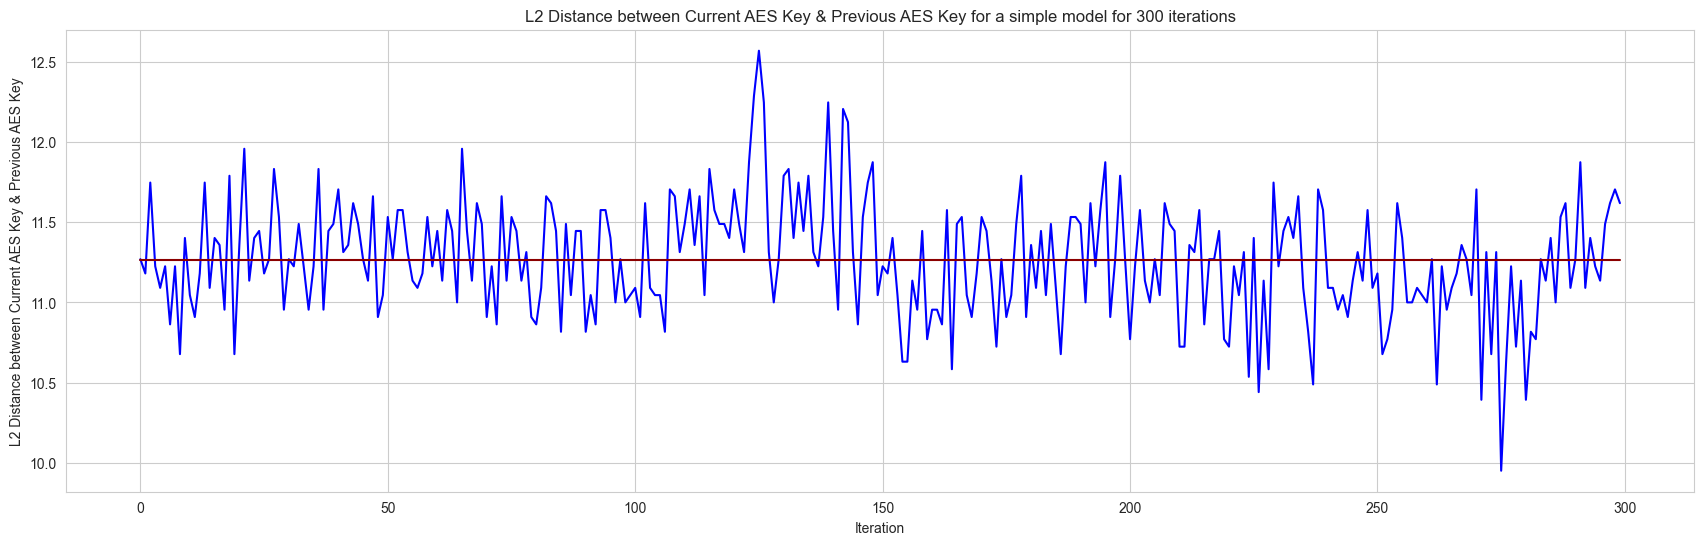

In [34]:
test_next_aes_key_l2dist_with_previous_aes_key(use_complex_model=False, iterations=300)

### Experiment 2.1: Outome
- L2 Distance between two consecutively generated keys using Simple ANN seems to be random indicating that knowing one AES Key will not help is guessing the next AES Key with the current design of using MD5 hashes of random string and UTC time in seconds

### Experiment 2.2
- Use a complex ANN
- Generate AES key with random strings and utc time
- Check if there is any pattern in L2 Distance between current AES Key bits and previous AES Key bits

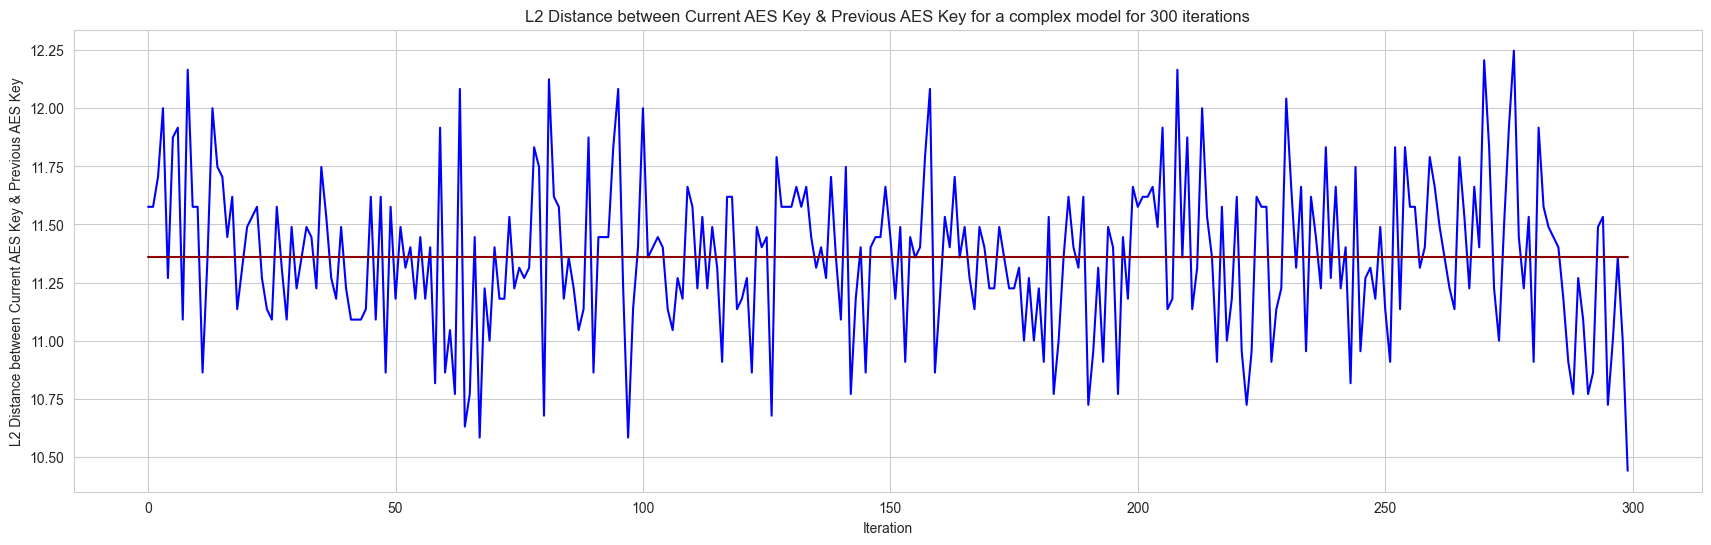

In [35]:
test_next_aes_key_l2dist_with_previous_aes_key(use_complex_model=True, iterations=300)

### Experiment 2.2: Outome
- L2 Distance between two consecutively generated keys using Complex ANN seems to be random indicating that knowing one AES Key will not help is guessing the next AES Key with the current design of using MD5 hashes of random string and UTC time in seconds

## Experiment 3: Extract Kaggle dataset, generate AES Keys and carry out observations
- From the random string MD5 hashes present in the dataset (https://www.kaggle.com/datasets/pavelbiz/random-hashes-md5-derived-from-random-strings), pick few records randomly and generate AES keys for each record using current UTC time MD5 hash.

In [36]:
def create_aes_keys_for_dataset_samples(random_indexes, use_simple_model=True):
    # use a simple model
    if use_simple_model == True:
        DF_SAMPLES_PATH = drive_path+'/dataset/df_samples_simple.csv'
        model = generate_ANN(use_complex_model=False)
    else:
        # use a complex model
        DF_SAMPLES_PATH = drive_path+'/dataset/df_samples_complex.csv'
        model = generate_ANN(use_complex_model=True)

    if os.path.exists(DF_SAMPLES_PATH) == False:
        dataset_file_path = drive_path+'/dataset/data.csv'
        df = pd.read_csv(dataset_file_path)
        df_samples = df.loc[random_indexes].copy()
        df_samples.reset_index(inplace=True)

        df_samples['utc'] = 0
        df_samples['utc_md5'] = '.'
        df_samples['input_str'] = '.'
        df_samples['aes_key'] = '.'

        for i in range(0,SAMPLES):
            random_string = str(df_samples.iloc[i]['sourcestring'])
            utc_time = int(time.time())
            df_samples.loc[i,'utc'] = utc_time
            df_samples.loc[i,'utc_md5'] = get_md5_hex_string(input_string=str(utc_time))
            df_samples.loc[i,'aes_key'],_,_, df_samples.loc[i,'input_str'] = generate_aes_key(model, random_string, utc_time)

        df_samples.to_csv(DF_SAMPLES_PATH)
    else:
        df_samples = pd.read_csv(DF_SAMPLES_PATH)
    return df_samples

In [37]:
SAMPLES = 20000
extract_dataset(drive_path, zip_file_path='/archive.zip',data_folder_path="/dataset")
dataset_file_path = drive_path+'/dataset/data.csv'
df = pd.read_csv(dataset_file_path)
random_indexes = random.sample(range(0, df.shape[0]), SAMPLES)
# create AES Keys using simple ANN
df_samples_simple = create_aes_keys_for_dataset_samples(random_indexes=random_indexes, use_simple_model=True)
# create AES Keys using complex ANN
df_samples_complex = create_aes_keys_for_dataset_samples(random_indexes=random_indexes, use_simple_model=False)

### Experiment 3.1: Total number of different bits between input bits and output bits
- From the dataset samples, get total number of difference of bits per record between inputs bits and output bits

- Significance: The number of different bits indicate that input and output and seperated in the vector space and that this distance varies across different inputs fed to the ANN

In [38]:
df_samples_simple.head()

,Unnamed: 0,index,sourcestring,resulthash,utc,utc_md5,input_str,aes_key
0,0,1739029,"HX%g6P{kzjpp.Zk(,6/zxqrz%T-P%l;",8b20f75c10f432a5c5d18a249f419b21,1683231963,850f53683b8b814440b08f8cd02e7375,c09b0855bb2f36e00745ea654a099832b022e702c0dd48...,adefcc8b1c2d6ba6ecf4ab44d73ad245b8ab2a8178b5de...
1,1,9561680,5k#;nAhlo=<F+~p=:8,ed17e41ee5ea47805460dbae32a0dee3,1683231964,fd16c4b1e4ae21e49d187b4ff2755b21,fdf3033ef83047a9fc32ecdc242bd41063712940b7cf98...,b5becccf128003b657f46b040fe8ae453e3900f9f89dde...
2,2,9804352,]]POcLJ'M52,38e13b32eda49f198c168609eaab167d,1683231964,fd16c4b1e4ae21e49d187b4ff2755b21,5fd1a9165a9a4f09fcb2cc7486ab5692c1f10368956d10...,f0db88cf1288a72452d66b047dbabe45ba3902fb78b19e...
3,3,4953983,$T7C(c<2^K?eo&ETh_P^&31)#2>,69f8e217ae89265df924915a4b25fbe1,1683231964,fd16c4b1e4ae21e49d187b4ff2755b21,7dd3ab94f818472bdcb8c4d60c2976b2ebd30960974732...,b4eae8cb1688a3a442d66f047fb8ba45ba3b09ab7897fe...
4,4,8379912,iI'7DZ=P -4gqDr4ie[<%&Az^hD;u,ab2709fae1eec11f88de3bab04ad76ad,1683231964,fd16c4b1e4ae21e49d187b4ff2755b21,dddb093e5092ef89fc12ecfca40356bac1d1a3e81fcf98...,f092ae8f168067a452d66b444fea9a45fe390b997893fe...


In [39]:
# create and inputs vs outputs dataframe
input_columns = ['i'+str(i) for i in range(0 ,256)]
output_columns = ['o'+str(i) for i in range(0 ,256)]
columns = input_columns + output_columns
bits_df = pd.DataFrame(columns=columns)
bits_df.head()

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,o246,o247,o248,o249,o250,o251,o252,o253,o254,o255


In [40]:
bit_difference = []
for i in range(0, SAMPLES):
    input_array = convert_hex_string_to_binary_array(df_samples_simple.iloc[i]['input_str'])
    output_array = convert_hex_string_to_binary_array(df_samples_simple.iloc[i]['aes_key'])
    bit_diff = get_total_different_bits(input_array, output_array)
    bit_difference.append(bit_diff)
    row = {}
    for j in range(0,256):
        row['i'+str(j)] = input_array[j]
        row['o'+str(j)] = output_array[j]
    bits_df.loc[len(bits_df.index)] = row
bits_df.head()

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,o246,o247,o248,o249,o250,o251,o252,o253,o254,o255
0,1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,1,1,1,1,0,1,1,1,...,0,0,1,0,1,0,0,0,1,1
2,0,1,0,1,1,1,1,1,1,1,...,0,0,1,0,1,0,0,0,1,1
3,0,1,1,1,1,1,0,1,1,1,...,0,1,1,0,1,0,0,0,0,1
4,1,1,0,1,1,1,0,1,1,1,...,0,0,1,0,1,0,0,0,0,1


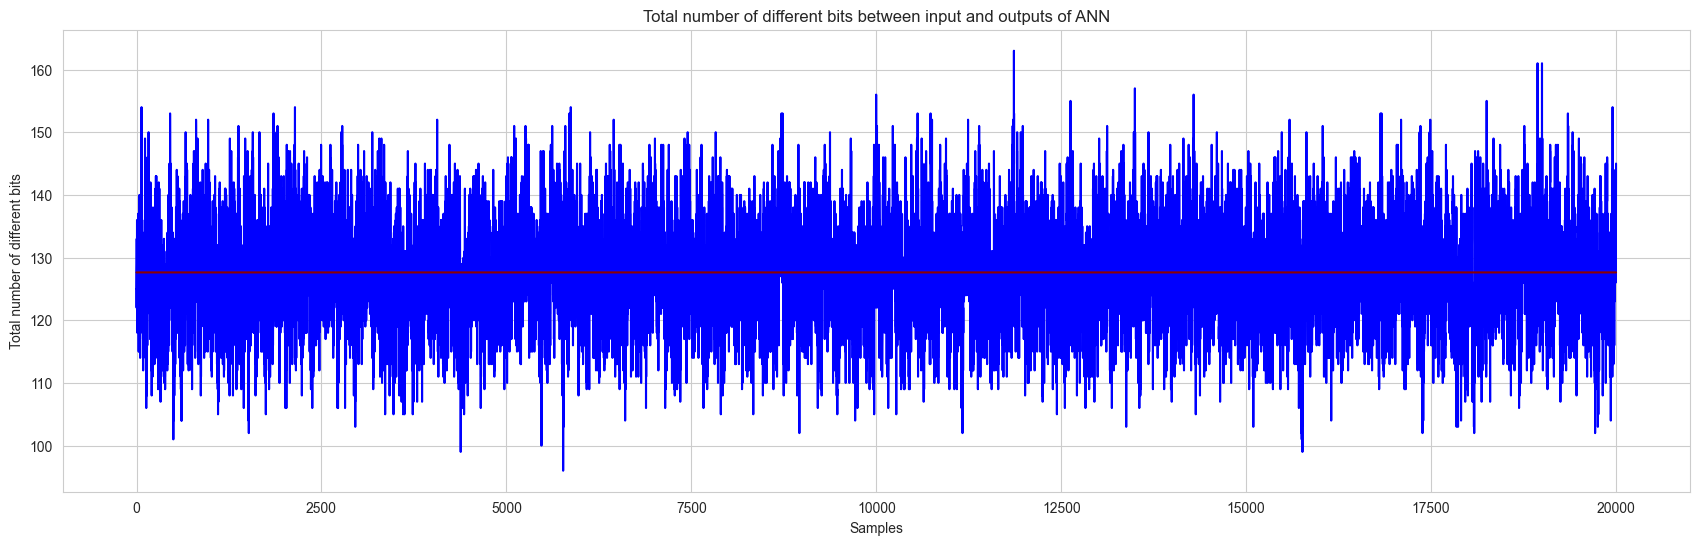

In [41]:
plot_arr(arr=bit_difference, xlabel='Samples', ylabel='Total number of different bits', title='Total number of different bits between input and outputs of ANN')

### Experiment 3.1: Outome
- Average number of different bits between inputs and outputs (AES Key) seem to be about 130 indicating that out of 256 bits each, more than half bits are different making it a good choice for security application for dynamically generated AES Keys
- The number of different bits fluctuate between a large range away from zero which implies ANN is producing varied output bits when compared to the inputs supplied

### Experiment 3.2: Input bits vs ANN AES Key Output bits correlation
- From the dataset samples, check correlation of input bits vs output bits

- Significance: If there is negigible or weak correlation between input bits and output bits, it can be proven that guessing ANN output AES Key given the inputs would be practivally impossible. Again aids the argument of using ANNs for security.

In [42]:
# take first 1000 records from bits_df dataframe for checking correlation matrix
bits_df_1000 = bits_df.head(1000)
bits_df_1000 = bits_df_1000.astype('int')
bits_df_corr = bits_df_1000.corr()
bits_df_corr.head()

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,o246,o247,o248,o249,o250,o251,o252,o253,o254,o255
i0,1.000000,-0.053975,0.035956,-0.032126,0.040022,-0.036042,0.013949,-0.022231,-0.003957,0.002107,...,0.123178,-0.080092,NaN,-0.040973,0.040733,-0.033829,NaN,-0.007193,0.010257,-0.064224
i1,-0.053975,1.000000,-0.037542,0.022763,0.001840,0.170337,-0.019562,-0.022796,-0.066377,-0.072940,...,-0.113011,0.040113,NaN,-0.011391,0.021207,-0.098135,NaN,-0.085252,-0.032267,-0.013760
i2,0.035956,-0.037542,1.000000,-0.041443,0.056328,-0.000540,0.049201,-0.012445,0.036685,0.019595,...,-0.005338,0.077545,NaN,0.088164,-0.003561,-0.112388,NaN,0.037600,-0.027215,-0.077110
i3,-0.032126,0.022763,-0.041443,1.000000,-0.003544,0.031210,0.040771,0.215237,-0.011002,-0.067771,...,-0.188153,-0.089356,NaN,0.040659,0.052664,0.051689,NaN,0.039349,0.118343,-0.126757
i4,0.040022,0.001840,0.056328,-0.003544,1.000000,-0.003821,0.006283,0.034914,0.023787,-0.002524,...,0.011393,0.032730,NaN,0.001767,0.039506,-0.006453,NaN,0.025191,-0.087497,-0.005962


In [43]:
bits_df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512 entries, i0 to o255
Columns: 512 entries, i0 to o255
dtypes: float64(512)
memory usage: 2.0+ MB


In [44]:
# make the correlation matrix between input and output bit columns
input_cols = ['i'+str(i) for i in range(0, 256)]
output_cols = ['o'+str(i) for i in range(0, 256)]
bits_df_corr.drop(index=input_cols, inplace=True)
bits_df_corr.drop(columns=output_cols, inplace=True)
bits_df_corr.head()

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,i246,i247,i248,i249,i250,i251,i252,i253,i254,i255
o0,0.044722,0.068798,-0.002695,0.085763,0.045802,-0.001617,0.019944,0.082884,0.001976,-0.062767,...,-0.047434,0.063811,-0.041872,0.002875,-3.152654e-17,-0.071053,-0.021375,0.004135,0.064161,0.013068
o1,-0.052233,-0.147206,-0.018277,0.177249,-0.098649,0.127915,0.036512,0.092631,0.042463,0.068416,...,-0.019255,-0.033677,0.001110,0.280958,4.814356e-02,0.017210,0.016938,-0.025056,-0.020416,0.008214
o2,-0.110489,0.108197,0.011536,0.113125,-0.059755,0.104216,-0.049918,0.042066,0.020342,-0.091954,...,0.013004,0.067144,0.024964,0.094814,1.257942e-02,-0.042009,0.092675,-0.016580,0.023916,0.089831
o3,-0.063992,0.156127,-0.009276,0.143849,0.086208,-0.025307,-0.031003,0.082025,-0.023334,-0.016676,...,-0.005020,0.130592,0.017791,0.023928,3.376464e-02,-0.039045,0.002151,0.058953,0.019534,0.175683
o4,-0.062166,0.022430,-0.008955,0.032122,-0.083101,0.110199,0.024775,-0.169582,-0.007736,0.077919,...,-0.054042,0.063254,0.050150,-0.040517,-2.407336e-02,0.257912,-0.115044,0.033603,0.029984,0.000513


In [45]:
# see the last few records in bits_df_corr dataframe 
bits_df_corr.tail()

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,i246,i247,i248,i249,i250,i251,i252,i253,i254,i255
o251,-0.033829,-0.098135,-0.112388,0.051689,-0.006453,-0.111319,-0.025840,0.126659,0.069228,0.080690,...,-0.144414,-0.026888,0.017579,-0.112896,-0.013170,0.023411,0.014207,-0.012138,0.032032,-0.053979
o252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
o253,-0.007193,-0.085252,0.037600,0.039349,0.025191,-0.097084,-0.001024,0.097840,-0.012477,0.071275,...,0.090611,-0.103537,0.030704,-0.016928,-0.018859,-0.102290,0.018914,0.019984,0.002534,0.041491
o254,0.010257,-0.032267,-0.027215,0.118343,-0.087497,-0.106865,0.071199,0.098264,-0.022302,-0.108397,...,-0.001250,0.064868,-0.002364,-0.037388,0.022631,-0.095763,0.010882,0.003996,0.003569,0.017601
o255,-0.064224,-0.013760,-0.077110,-0.126757,-0.005962,-0.039921,-0.012856,0.058429,0.036484,-0.028928,...,-0.060355,-0.013094,0.031450,-0.011697,-0.010551,-0.027050,0.005508,0.121476,0.057372,-0.039834


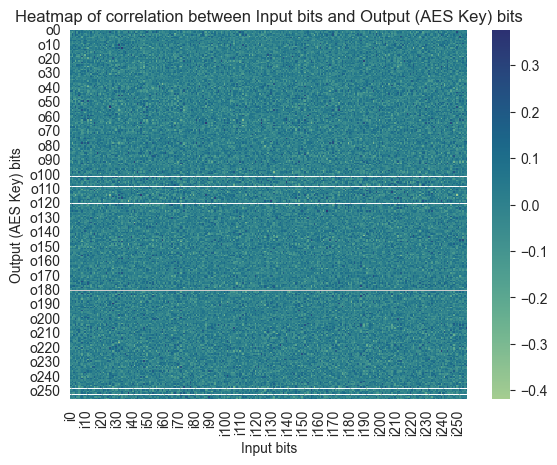

In [46]:
# draw correlation heatmap to see if ingeneral do input and output bits show any correlation
sns.heatmap(data=bits_df_corr, cmap='crest')
plt.xlabel('Input bits')
plt.ylabel('Output (AES Key) bits')
plt.title('Heatmap of correlation between Input bits and Output (AES Key) bits')
plt.show()

#### Plot correlation histogram to know how the correlation values are distributed.
- Distribution of bit correlation around 0 indicates weak correlation between inputs and outputs i.e, no linear relationship between input and output bits

min correlation:-0.42
max correlation:0.38


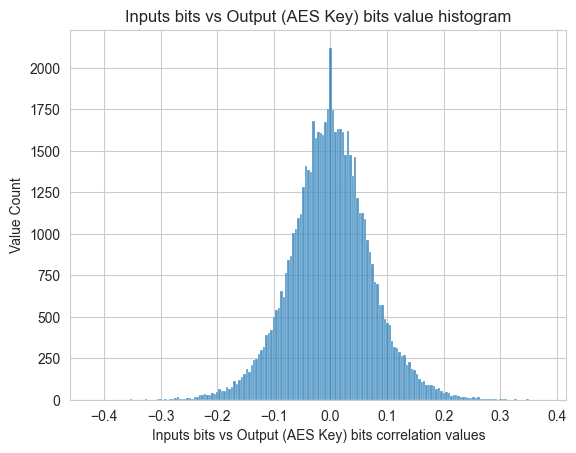

In [47]:
flat_correlation_arr = []
for c in bits_df_corr.columns:
    flat_correlation_arr.extend(bits_df_corr[c])

print(f'min correlation:{round(min(flat_correlation_arr),2)}')
print(f'max correlation:{round(max(flat_correlation_arr),2)}')
flat_correlation_arr = list(filter(lambda x: x  != None, flat_correlation_arr))
sns.histplot(flat_correlation_arr)
plt.xlabel('Inputs bits vs Output (AES Key) bits correlation values')
plt.ylabel('Value Count')
plt.title('Inputs bits vs Output (AES Key) bits value histogram')
plt.show()

### Experiment 3.2: Outome
- Heatmap of correlation between input bits and output bits (AES Key) indicates that there is a weak correlation which implies that it would be practically impossible to guess the AES Key output bits given the inputs supplied to ANN as the relationship is not linear
- The histogram of the all the correlation values collect indicates a range of values centering around 0 and spreading between -0.4 to 0.4 which indicate a weak correlation.

### Experiment 3.3: Check bits distribution of 1s and 0s via histogram
- From the dataset samples, collect a few random bit positions and check the number of 0s and 1s 

- Significance: Number of 0s and 1s should be varying and not indicating any constant relation like =,< or > 

['o234', 'o47', 'o242', 'o149', 'o224', 'o97', 'o247', 'o82', 'o71', 'o122']


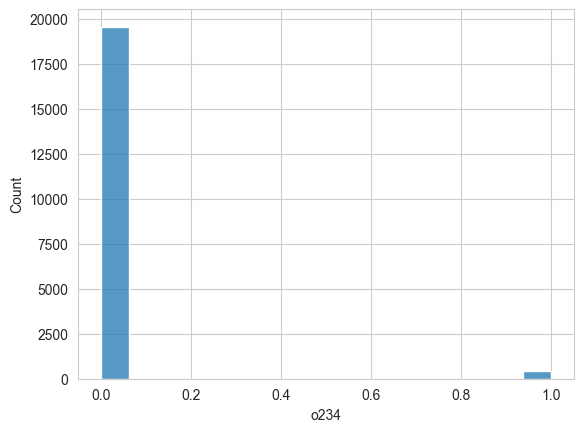

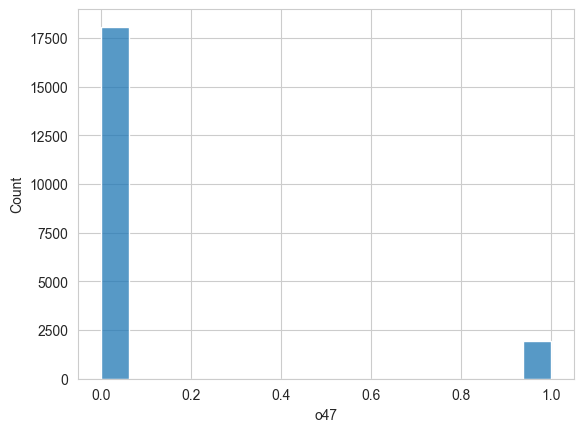

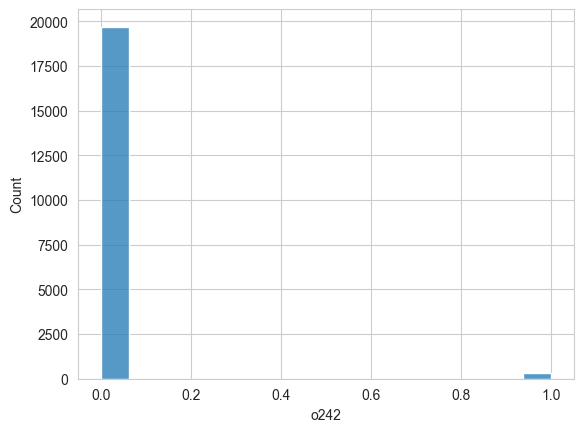

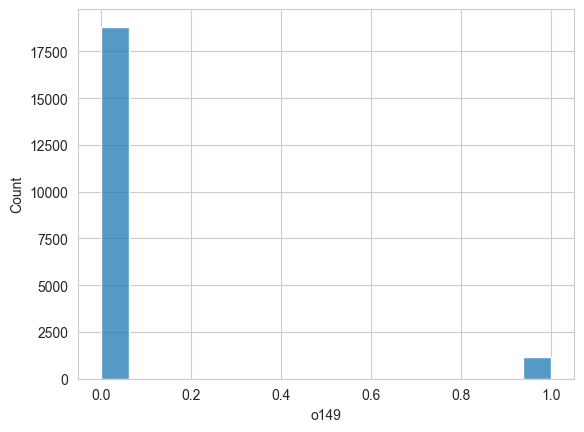

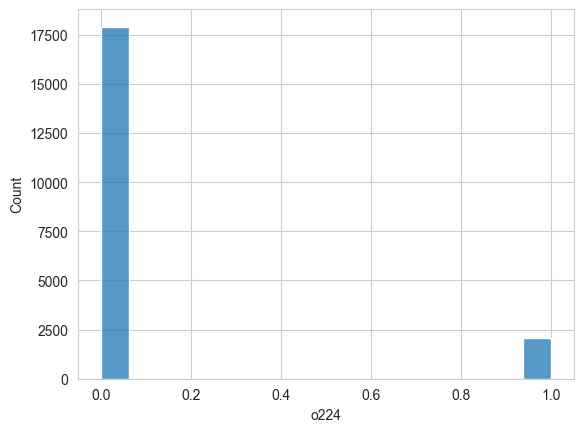

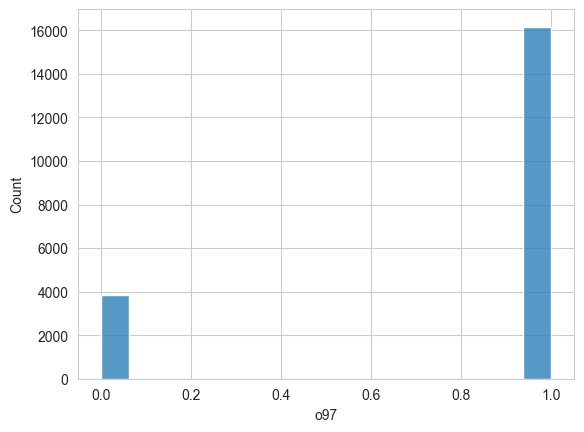

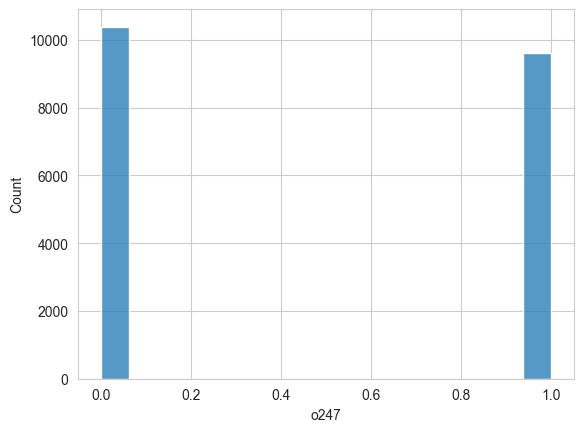

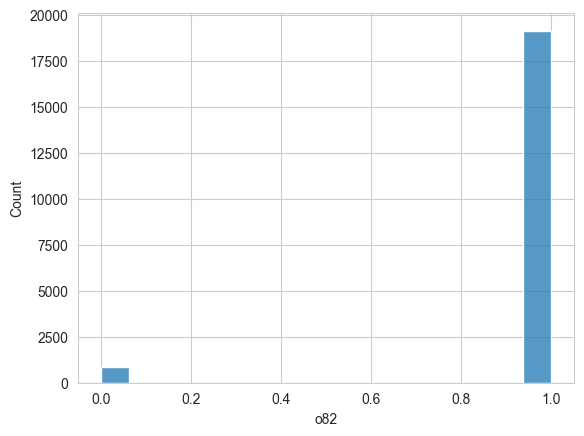

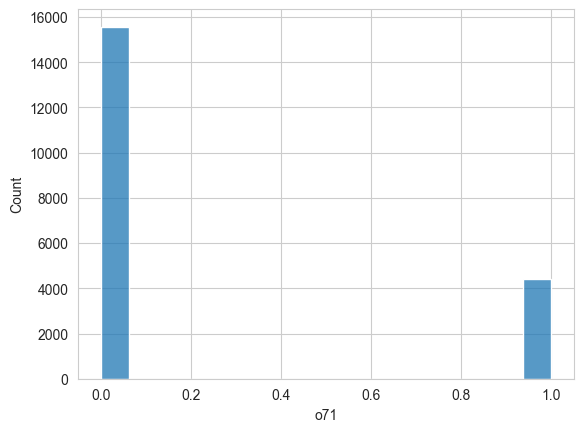

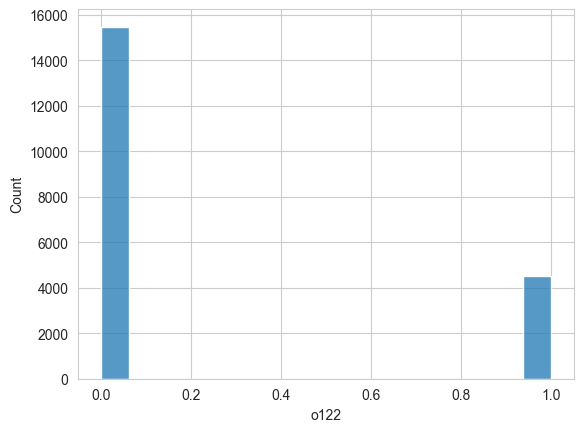

In [48]:
# lets choose few random bit positions and check how 1s and 0s are distributed while generating various AES keys
selected_columns = random.sample(output_columns, 10)
print(selected_columns)
for c in selected_columns:
  sns.histplot(bits_df[c])
  plt.show()

### Experiment 3.3: Outome
- Bit positions do not show any specific trend of dominating 0s or dominating 1s. They are practically random interms of their numbers

### Experiment 3.4: Check bit correlation for Complex ANN 
- To Check if correlation between input and output bits for a complex ANN is weaker than that of a simple ANN

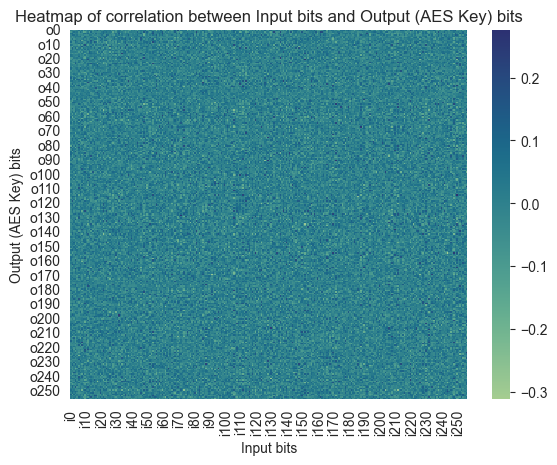

min correlation:-0.31
max correlation:0.28


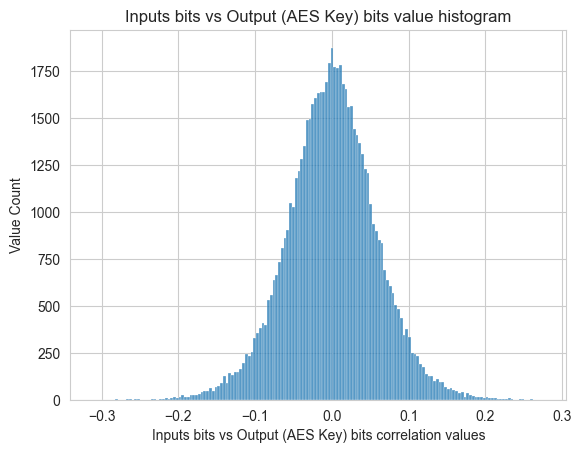

In [49]:
# create and inputs vs outputs dataframe
input_columns = ['i'+str(i) for i in range(0 ,256)]
output_columns = ['o'+str(i) for i in range(0 ,256)]
columns = input_columns + output_columns
bits_df = pd.DataFrame(columns=columns)
bits_df.head()

for i in range(0, SAMPLES):
    input_array = convert_hex_string_to_binary_array(df_samples_complex.iloc[i]['input_str'])
    output_array = convert_hex_string_to_binary_array(df_samples_complex.iloc[i]['aes_key'])
    row = {}
    for j in range(0,256):
        row['i'+str(j)] = input_array[j]
        row['o'+str(j)] = output_array[j]
    bits_df.loc[len(bits_df.index)] = row

# take first 1000 records from bits_df dataframe for checking correlation matrix
bits_df_1000 = bits_df.head(1000)
bits_df_1000 = bits_df_1000.astype('int')
bits_df_corr = bits_df_1000.corr()

# make the correlation matrix between input and output bit columns
input_cols = ['i'+str(i) for i in range(0, 256)]
output_cols = ['o'+str(i) for i in range(0, 256)]
bits_df_corr.drop(index=input_cols, inplace=True)
bits_df_corr.drop(columns=output_cols, inplace=True)

# draw correlation heatmap to see if ingeneral do input and output bits show any correlation
sns.heatmap(data=bits_df_corr, cmap='crest')
plt.xlabel('Input bits')
plt.ylabel('Output (AES Key) bits')
plt.title('Heatmap of correlation between Input bits and Output (AES Key) bits')
plt.show()

flat_correlation_arr = []
for c in bits_df_corr.columns:
    flat_correlation_arr.extend(bits_df_corr[c])

print(f'min correlation:{round(min(flat_correlation_arr),2)}')
print(f'max correlation:{round(max(flat_correlation_arr),2)}')
flat_correlation_arr = list(filter(lambda x: x  != None, flat_correlation_arr))
sns.histplot(flat_correlation_arr)
plt.xlabel('Inputs bits vs Output (AES Key) bits correlation values')
plt.ylabel('Value Count')
plt.title('Inputs bits vs Output (AES Key) bits value histogram')
plt.show()

### Experiment 3.4: Outome
- There seems to be weakening of correlation between input and output bits when a complex ANN is used
- Complex ANN would make a better choice than Simple ANN if the Client is expected to hold a given ANN for longer use but a complex ANN consumes more storage space and runtime space
- For practical usage, simple ANN model should be sufficient to keep generating newer AES keys per iteration in the Client-Server message exchanges

## Experiment 4: To prove there can't be a Learner-ANN that can eventually converge onto the existing ANN model by continuosuly learning the ANN's outputs for given inputs

In [50]:
EPISODES = 100000

EPOCHS_PER_TRAINING = 1

# state tracking will kickstart after these many episodes.
START_TRACKING_EVERY = EPISODES//20

BATCH_SIZE = 256

VERBOSE = True

print(f"Total Episodes: {EPISODES}")
print(f"States will be tracked after every [{START_TRACKING_EVERY}] Episodes")

Total Episodes: 100000
States will be tracked after every [5000] Episodes


In [51]:
ann = generate_ANN(use_complex_model=False)
learner_ann = generate_ANN(use_complex_model=False)

memory = []
model_stats_arr = []
predicted_aes_key_l2_diff_actual_arr = []
longest_common_bit_seq_len_arr = []
total_different_bits_arr = []

for episode in range(EPISODES):
    episode_start_time = datetime.now()
    model_stats = None
    if len(memory) > BATCH_SIZE:
        mini_batch = random.sample(memory, BATCH_SIZE)
        X = []
        y = []
        for sample in mini_batch:
            X.append(sample[0])
            y.append(sample[1])
        X = np.array(X)
        y = np.array(y)
        model_stats = learner_ann.fit(x=X, y=y, batch_size=BATCH_SIZE, epochs=EPOCHS_PER_TRAINING, verbose=0)
        model_stats_arr.append(model_stats)
    
    random_string = str(uuid.uuid4())
    utc_time = int(time.time())
    input_bits = join_binary_strings_as_array(get_binary_md5(random_string), get_utc_md5(utc_time))
    aes_key, aes_key_256_bits, aes_key_raw_bits, _= generate_aes_key(ann, random_string, utc_time)
    memory.append((input_bits, aes_key_raw_bits, aes_key))
    # predict generate AES key from learner ANN and compare with that of ANN
    learner_aes_key, learner_aes_key_256_bits, _, _= generate_aes_key(learner_ann, random_string, utc_time)
    
    total_different_bits = get_total_different_bits(learner_aes_key_256_bits, aes_key_256_bits)
    l2_dist = get_l2_dist(learner_aes_key_256_bits, aes_key_256_bits)
    lcs = get_longest_number_of_contiguous_bits(aes_key_256_bits, learner_aes_key_256_bits)
    
    total_different_bits_arr.append(total_different_bits)
    predicted_aes_key_l2_diff_actual_arr.append(l2_dist)
    longest_common_bit_seq_len_arr.append(lcs)
    
    if (VERBOSE) and ((episode % START_TRACKING_EVERY == 0) or (l2_dist == 0)):
        print(f'====Iteration:{episode} Start=====')
        print(f'Longest Common bit seq length:{lcs}')
        print(f'l2_dist:{l2_dist}')
        if l2_dist == 0:
            print(f'Exact Learner Key generated:{learner_aes_key}, Original Key:{aes_key}')
        print(f'----Iteration:{episode} End=====')

====Iteration:0 Start=====
Longest Common bit seq length:8
l2_dist:11.789826122551595
----Iteration:0 End=====
====Iteration:5000 Start=====
Longest Common bit seq length:14
l2_dist:8.06225774829855
----Iteration:5000 End=====
====Iteration:10000 Start=====
Longest Common bit seq length:21
l2_dist:7.3484692283495345
----Iteration:10000 End=====
====Iteration:15000 Start=====
Longest Common bit seq length:12
l2_dist:8.774964387392123
----Iteration:15000 End=====
====Iteration:20000 Start=====
Longest Common bit seq length:12
l2_dist:7.937253933193772
----Iteration:20000 End=====
====Iteration:25000 Start=====
Longest Common bit seq length:17
l2_dist:7.745966692414834
----Iteration:25000 End=====
====Iteration:30000 Start=====
Longest Common bit seq length:15
l2_dist:7.0710678118654755
----Iteration:30000 End=====
====Iteration:35000 Start=====
Longest Common bit seq length:24
l2_dist:6.164414002968976
----Iteration:35000 End=====
====Iteration:40000 Start=====
Longest Common bit seq len

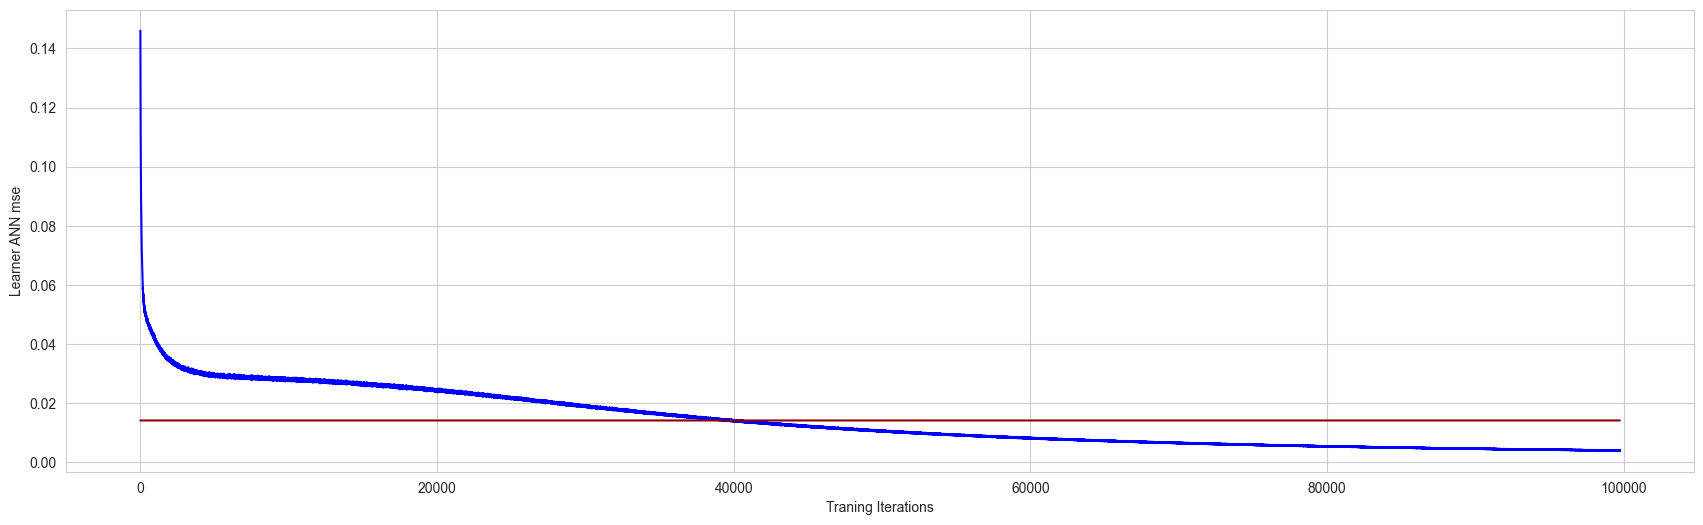

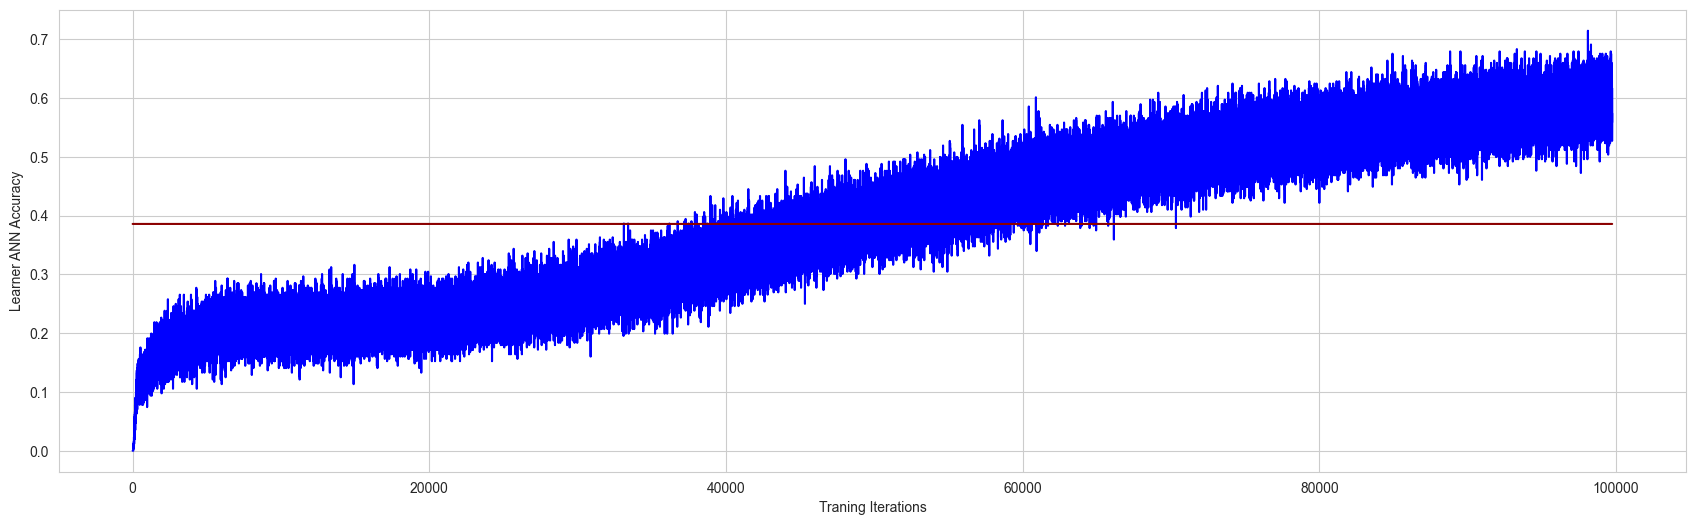

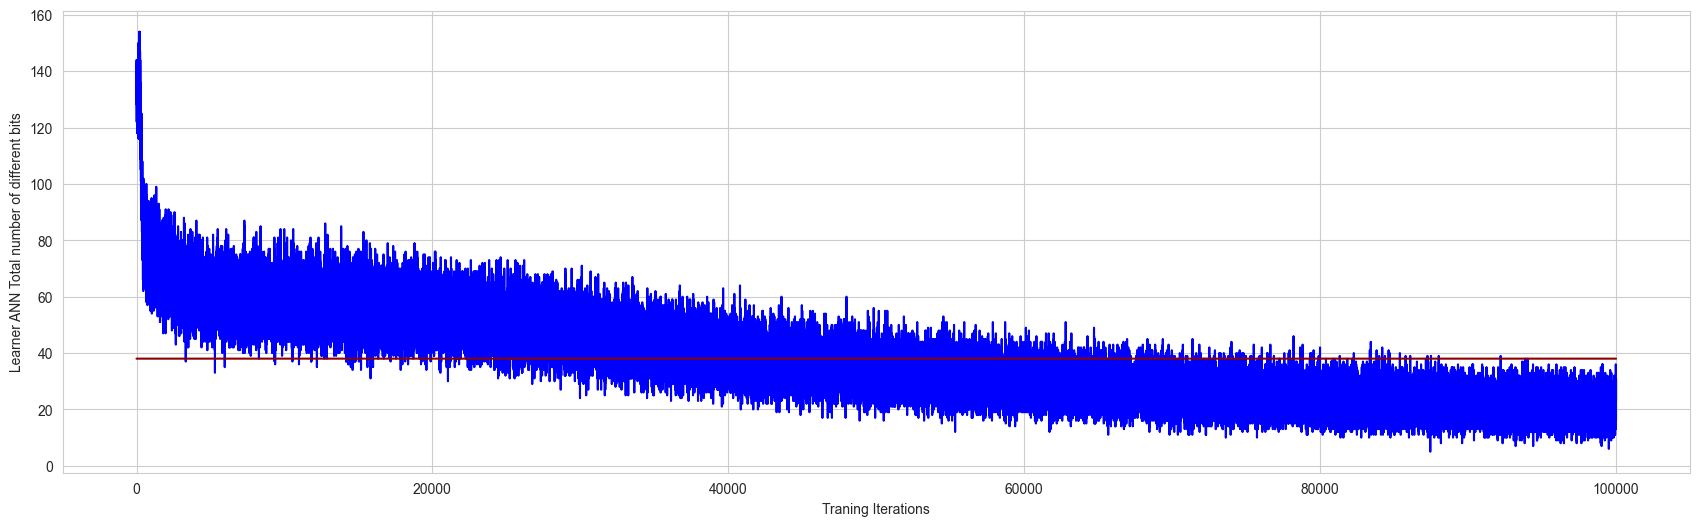

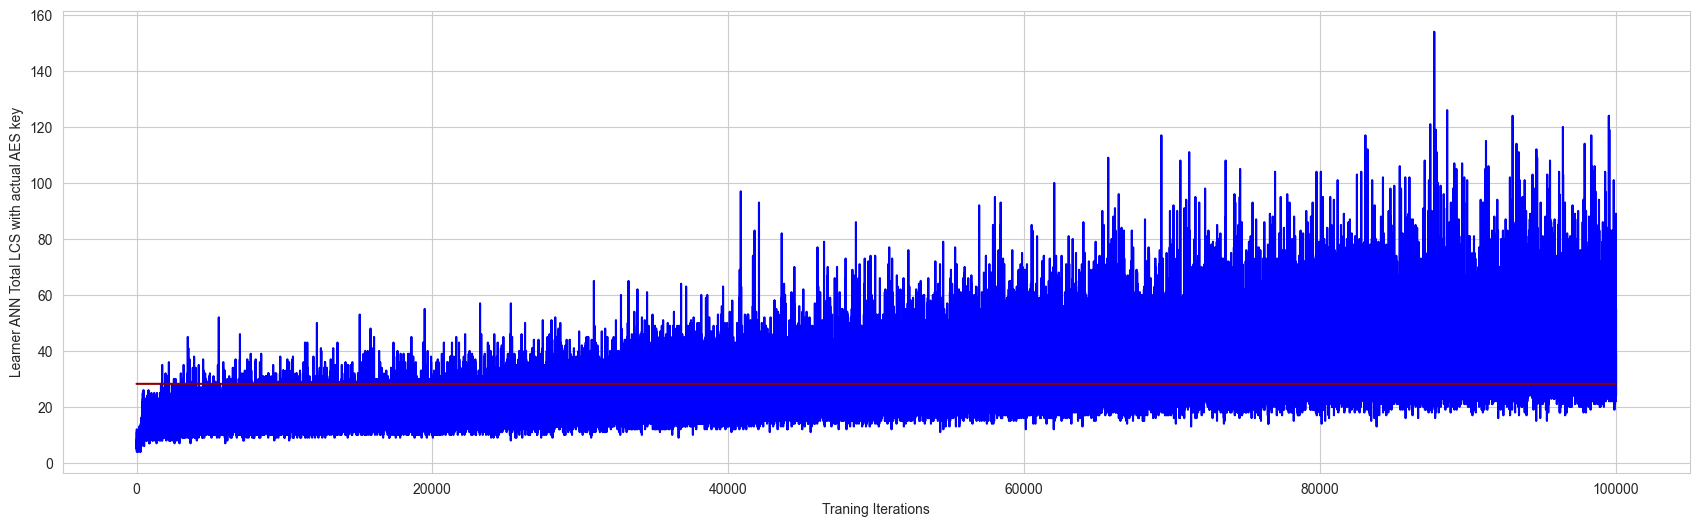

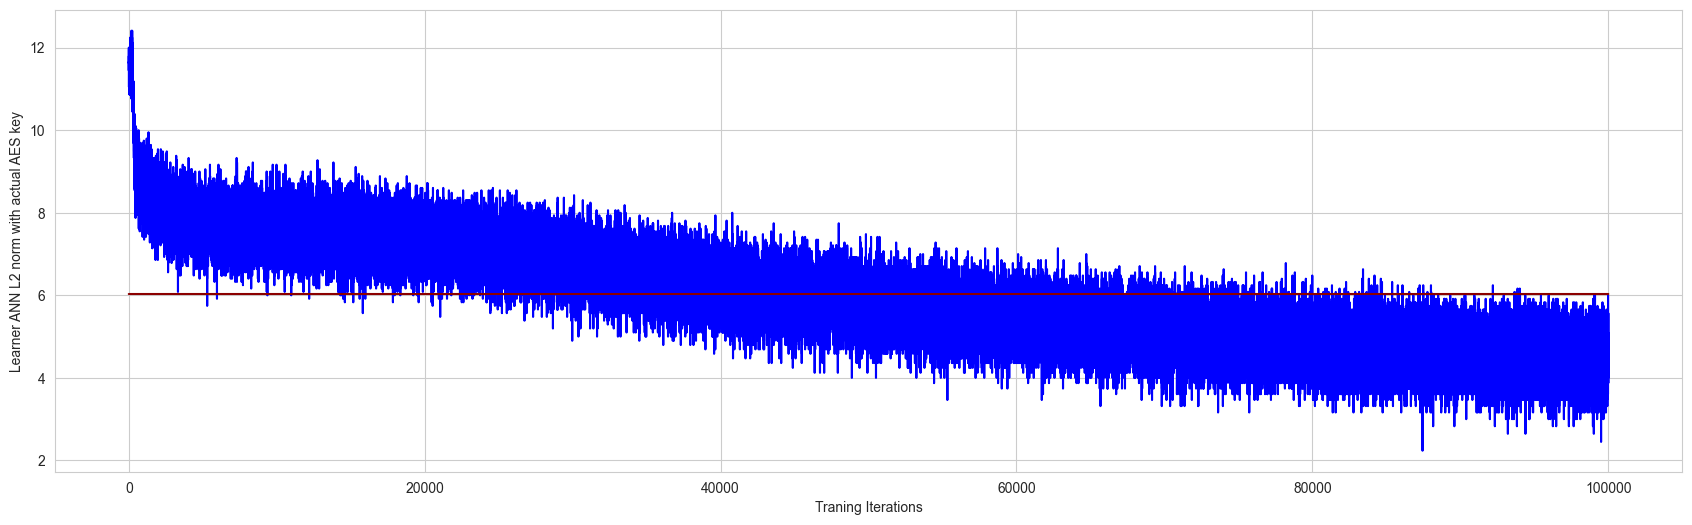

In [52]:
mse_arr = []
accuracy_arr=[]
for model_stats in model_stats_arr:
    mse_arr.extend(model_stats.history['mse'])
    accuracy_arr.extend(model_stats.history['accuracy'])

plot_arr(mse_arr, xlabel='Traning Iterations', ylabel='Learner ANN mse')
plot_arr(accuracy_arr, xlabel='Traning Iterations', ylabel='Learner ANN Accuracy')

plot_arr(total_different_bits_arr, xlabel='Traning Iterations', ylabel='Learner ANN Total number of different bits')
plot_arr(longest_common_bit_seq_len_arr, xlabel='Traning Iterations', ylabel='Learner ANN Total LCS with actual AES key')
plot_arr(predicted_aes_key_l2_diff_actual_arr, xlabel='Traning Iterations', ylabel='Learner ANN L2 norm with actual AES key')

### Experiment 4: Outome
- Learner ANN's mse was going down with training but stagnating after point of time in training. Even if the mse value are minimizing the AES Key bits calculations give Learner AES Keys which are far away from actual ANN's AES Keys interms of L2 Norm (euclidean distance)
- Learner ANN's accuracy is also capping after certain number of training episodes
- Learner ANN's total number of common bits rises but starts capping
- Learner ANN's L2 distance with AES Keys if ANN reduces but flattens out
- Learner ANN's graphs show a range of values instead of a highly accurate line graph indicating that Learner ANN can utmost reach a poor approximation of original ANN but cannot exactly converge onto the randomly generated ANN

### All the points above indicate that it is practically impossible for a Learner ANN to converge onto real ANN even with the knowledge of inputs and the outputs. Always the next random input would have surprise value to the Learner ANN

## Experiment 5: Save and Load ANN model and perform AES Encryption and Decryption
- Significance: Ability for Server to produce ANN models, store them, share them with clients and perform AES Encryption and Decryption operations using AES keys generated using those ANN models

In [22]:
simple_model = generate_ANN()
# save simple model in h5 format
simple_model_file_name = save_model(simple_model,is_complex=False,format='h5', drive_path=drive_path)
print(f'simple_model_file_name={simple_model_file_name}')
# load simple model
simple_model = keras.models.load_model(simple_model_file_name)

# save in tfjs format for js clients (browser)
simple_model_tfjs_folder_name = save_model(simple_model,is_complex=False,format='tfjs', drive_path=drive_path)
print(f'simple_model_tfjs_folder_name={simple_model_tfjs_folder_name}')

complex_model = generate_ANN(use_complex_model=True)
# save complex model in h5 format
complex_model_file_name = save_model(complex_model,is_complex=True,format='h5', drive_path=drive_path)
print(f'complex_model_file_name={complex_model_file_name}')
# load simple model
complex_model = keras.models.load_model(complex_model_file_name)

# save in tfjs format for js clients (browser)
complex_model_tfjs_folder_name = save_model(complex_model,is_complex=True,format='tfjs', drive_path=drive_path)
print(f'complex_model_tfjs_folder_name={complex_model_tfjs_folder_name}')

simple_model_file_name=./models/simple_model_h5_1683436012.195275.h5
simple_model_tfjs_folder_name=./models/simple_tfjs_model_1683436012.195275
complex_model_file_name=./models/complex_model_h5_1683436012.195275.h5
complex_model_tfjs_folder_name=./models/complex_tfjs_model_1683436012.195275


#### With the saved model, lets test encryption and decryption of non-ascii data

In [34]:
BLOCK_SIZE = 16
pad = lambda s: s + (BLOCK_SIZE - len(s) % BLOCK_SIZE) * chr(BLOCK_SIZE - len(s) % BLOCK_SIZE)
unpad = lambda s: s[:-s.index(s[len(s) - 1:])]

def pad_bytes(plain_text = '', block_size=BLOCK_SIZE):
    pad_with_chr=chr(0)
    plain_text_utf8 = plain_text.encode('utf-8')
    padded_bytes = ''
    if len(plain_text) % block_size != 0:
        bytes_to_pad = block_size - len(plain_text) % block_size
        padding_bytes = bytes_to_pad*pad_with_chr
        padded_bytes = plain_text + padding_bytes
    else:
        padded_bytes = plain_text
    return padded_bytes

def unpad_bytes(decrypted_bytes_padded):
    if len(decrypted_bytes_padded)%16 == 0:
        return decrypted_bytes_padded
    
    last_char_padded = decrypted_bytes_padded[len(decrypted_bytes_padded) - 1:]
    last_char_padded_first_occurance = decrypted_bytes_padded.index(last_char_padded)
    return decrypted_bytes_padded[:last_char_padded_first_occurance]

def do_aes_encrytion_and_decryption(model, plain_text="""Δ Δ, Й, ק ,م, ๗, あ, 叶, 葉, and 말."""):
    model = complex_model
    random_string = str(uuid.uuid4())
    utc_time = int(time.time())

    print(f'random_string={random_string}, utc_time={utc_time}')
    aes_key,_,_,_ = generate_aes_key(model, random_string, utc_time)
    print(f'aes_key={aes_key}')
    aes_key_bytes = bytes.fromhex(aes_key)
    cipher = AES.new(key=aes_key_bytes,mode=AES.MODE_ECB)
    print(f'plain_text = {plain_text}')

    # encode the plain text to base64 for avoiding non-ascii characters
    plain_text_b64encoded = bytes.decode(base64.encodebytes(plain_text.encode('utf-8')),'utf-8')
    # adding padding to make it multiple of BLOCK_SIZE
    padded_plain_text_bytes = pad_bytes(plain_text_b64encoded)
    print('padded_plain_text_bytes='+padded_plain_text_bytes)

    # encrypt base64 encoded plain text
    encrypted_base64 = base64.b64encode(cipher.encrypt(padded_plain_text_bytes.encode()))

    # decryption cycle
    # decode base64 string
    encrypted_text = base64.b64decode(encrypted_base64)

    # decrypt the padded bytes
    decrypted_bytes_padded = cipher.decrypt(encrypted_text)

    # unpad and recover the base64 encoded plain text
    decrypted_plain_text_base64 = bytes.decode(unpad_bytes(decrypted_bytes_padded))
    print(f'decrypted_plain_text_base64 = {decrypted_plain_text_base64}')

    decrypted_plain_text = base64.b64decode(decrypted_plain_text_base64)
    decrypted_plain_text = decrypted_plain_text.decode('utf-8')
    print(f'decrypted_plain_text = {decrypted_plain_text}')
    print(f'Is decoding proper = {decrypted_plain_text == plain_text}')

In [35]:
do_aes_encrytion_and_decryption(simple_model, plain_text='ウィキペディア日本語版')

random_string=5fec8eeb-a553-4ad3-af89-c524d699667c, utc_time=1683437287
aes_key=6098371a590f372b724271835c5f52210eda89907b5d46bb371eb950cea99470
plain_text = ウィキペディア日本語版
padded_plain_text_bytes=44Km44Kj44Kt44Oa44OH44Kj44Ki5pel5pys6Kqe54mI
   
decrypted_plain_text_base64 = 44Km44Kj44Kt44Oa44OH44Kj44Ki5pel5pys6Kqe54mI
   
decrypted_plain_text = ウィキペディア日本語版
Is decoding proper = True


In [36]:
do_aes_encrytion_and_decryption(complex_model, plain_text='(traditional Chinese: 中文維基百科; simplified Chinese: 中文维基百科; pinyin: Zhōngwén Wéijī Bǎikē')

random_string=1064f53d-687d-4070-8453-1811c6ed9454, utc_time=1683437288
aes_key=fe980f9935a8022771427dc347769c030cbecb9470ccf2eb761f51a19e888c21
plain_text = (traditional Chinese: 中文維基百科; simplified Chinese: 中文维基百科; pinyin: Zhōngwén Wéijī Bǎikē
padded_plain_text_bytes=KHRyYWRpdGlvbmFsIENoaW5lc2U6IOS4reaWh+e2reWfuueZvuenkTsgc2ltcGxpZmllZCBDaGlu
ZXNlOiDkuK3mlofnu7Tln7rnmb7np5E7IHBpbnlpbjogWmjFjW5nd8OpbiBXw6lpasSrIELHjmlr
xJM=
 
decrypted_plain_text_base64 = KHRyYWRpdGlvbmFsIENoaW5lc2U6IOS4reaWh+e2reWfuueZvuenkTsgc2ltcGxpZmllZCBDaGlu
ZXNlOiDkuK3mlofnu7Tln7rnmb7np5E7IHBpbnlpbjogWmjFjW5nd8OpbiBXw6lpasSrIELHjmlr
xJM=
 
decrypted_plain_text = (traditional Chinese: 中文維基百科; simplified Chinese: 中文维基百科; pinyin: Zhōngwén Wéijī Bǎikē
Is decoding proper = True


### Experiment 5: Outome
- Abilitity to save simple and complex ANN models in both h5 and tfjs formats suitable for Native and Browser based JS clients
- AES Encryption and Decryption depicted with dynamic AES key generated using simple and complex ANNs on ASCII and non-ASCII data containing unicode characters

## Experiment 6: Create a Python Client to interact with a Flask application server serving ANNs
- Test ANN Model fetching by sharing RSA Public key
- Test ANN Model Decryption using private RSA Key
- Load the Model, generate an ANN with random string and utc in seconds
- Verify if the server is able to decrypt the message and send a response using the same AES key with the original message
- Check replay attack by sending a stale request whose utc time stamp is beyond the tolerence value of 10 seconds set on flask server
- Try to send an future message whose utc time is in the future beyond the tolerence value of 10 seconds

In [37]:
# Setup: Assuming the FYKO Flask application is hosted on the same machine where this notebook is executing
SERVER_GET_ANN_ENDPOINT = "http://localhost:8000/get_ann"
SERVER_SEND_MESSAGE = "http://localhost:8000/send_message"

In [43]:
# Step 1: Generate an RSA Key Pair
print('\nGenerating RSA Key Pair.')
key = RSA.generate(2048)

# Step 2: Transform the Public Key into Base64 format to share it with the Server
print('\nTransforming the Public Key into Base64 format to share it with the Server.')
public_key = key.publickey()
rsa_pub_key_base64 = base64.b64encode(public_key.export_key()).decode("ascii")

# Step 3: Build payload to send to the server
print('\nBuilding payload request H5 model from the Server.')
get_ann_request = {
    "format": "h5",
    "rsa_public_key_2048_base64":rsa_pub_key_base64
}

# Step 4: Send a request to the Flask application and collect the encrypted model response
print('\nRequesting an ANN Model from Server.')
response = requests.post(SERVER_GET_ANN_ENDPOINT, json=get_ann_request)
response_json = json.loads(response.text)

# Step 5: Decrypt the Encrypted AES Key which was used to encrypt the model h5 file
print('\nDecrypting the random AES Key using which the model was encrypted.')
cipher_rsa = PKCS1_OAEP.new(key)
aes_key_encrypted_base64 = response_json['aes_key_encrypted']
aes_key_encrypted = base64.b64decode(aes_key_encrypted_base64)
aes_key_bytes = cipher_rsa.decrypt(aes_key_encrypted)

# Step 6: Decrypt the ann model using the AES key
print('\nDecrypting the model.')
ann_encrypted = base64.b64decode(response_json['ann_base64'])
aes_cipher = AES.new(key=aes_key_bytes,mode=AES.MODE_ECB)
ann_h5_base64_bytes_padded = aes_cipher.decrypt(ann_encrypted)
# unpad and recover the base64 encoded plain text
ann_h5_bytes_base64 = unpad_bytes(ann_h5_base64_bytes_padded)
ann_h5_base64 = base64.b64decode(ann_h5_bytes_base64)
ann_h5 = base64.b64decode(ann_h5_bytes_base64)

# Step 7: Save the model
print('\nSaving the decrypted model.')
ann_id = response_json['ann_id']
ann_id_file = open(ann_id, "wb")
ann_id_file.write(ann_h5)
ann_id_file.close()
print(f'ann_id={ann_id}')

# Step 8: Load the model
print('\nLoading the decrypted model.')
print(f'ann_id={ann_id}')
model = keras.models.load_model(ann_id)

# Step 9: Build message payload to send to the server
print('\nBuilding payload to send to the server.')
utc_time_seconds = int(time.time())
random_string = str(uuid.uuid4())
multilingual_string = "English: FYKO is a cool project \nTelugu: FYKO ఒక మంచి ప్రాజెక్ట్ \nHindi: FYKO एक अच्छा प्रोजेक्ट है \nPortugese: FYKO é um projeto legal \nThai: FYKO เป็นโครงการที่ยอดเยี่ยม \nChinese: FYKO是一個很酷的項目 \nJapanese: FYKOはクールなプロジェクトです \nKorean: FYKO는 멋진 프로젝트입니다 \nIrish: Is tionscadal fionnuar é FYKO \nArabic: FYKO مشروع رائع" 
# secret_message has a unique random id followed by a multilingual string to check encryption and decryption
secret_message = "message id:"+ str(uuid.uuid4()) + "\n" + multilingual_string
print(f'\nsecret_message: {secret_message}')
aes_key,_,_,_ = generate_aes_key(model, random_string, utc_time_seconds)
aes_key_bytes = bytes.fromhex(aes_key)
cipher = AES.new(key=aes_key_bytes,mode=AES.MODE_ECB)
# encode the plain text to base64 for avoiding non-ascii characters
secret_message_b64encoded = bytes.decode(base64.encodebytes(secret_message.encode('utf-8')),'utf-8')
secret_message_b64encoded_bytes = pad_bytes(secret_message_b64encoded)
# encrypt base64 encoded plain text
secret_message_encrypted_b64 = base64.b64encode(cipher.encrypt(secret_message_b64encoded_bytes.encode())).decode("ascii")
send_message = {
    "random_string":random_string,
    "utc_time_seconds": utc_time_seconds,
    "encrypted_message":secret_message_encrypted_b64,
    "ann_id":ann_id
}
print(f'\nrequest json={send_message}')

# Step 10: Send a request to the Flask application and collect the model response
print('\nSending request to the Server with encrypted message, random string, utc time and ann id.')
response = requests.post(SERVER_SEND_MESSAGE, json=send_message)
response_json = json.loads(response.text)
print(f'\nresponse_json={response_json}')

# Step 11: Verify if server was able to decrypt the message
print('\nVerifying decrypted message sent back by the Server:')
request_message = response_json.get('request_message')
if request_message != None:
    print(f'\nOriginal Message: {secret_message}')
    print(f'Message decoded by Server: {request_message}')
    print(f'Is the original secret message sent equal to the request message in response:{secret_message==request_message}')

# Step 12: Try sending a stale request which is older than 10 seconds to the server
print('\nReplay Attack Scenario:')
utc_time_seconds = int(time.time()) - 20
send_stale_message = {
    "random_string":random_string,
    "utc_time_seconds": utc_time_seconds,
    "encrypted_message":secret_message_encrypted_b64,
    "ann_id":ann_id
}
response = requests.post(SERVER_SEND_MESSAGE, json=send_stale_message)
response_json = json.loads(response.text)
print(f'send_stale_message response_json={response_json}')

# Step 13: Try sending a future request which is newer than 10 seconds to the server
print('\nFuture Request Scenario:')
utc_time_seconds = int(time.time()) + 20
send_future_message = {
    "random_string":random_string,
    "utc_time_seconds": utc_time_seconds,
    "encrypted_message":secret_message_encrypted_b64,
    "ann_id":ann_id
}
response = requests.post(SERVER_SEND_MESSAGE, json=send_future_message)
response_json = json.loads(response.text)
print(f'send_future_message response_json={response_json}')

# Step 14: Wrong random string
print('\nWrong random string scenario:')
utc_time_seconds = int(time.time())
send_wrong_inputs = {
    "random_string":"wrong one",
    "utc_time_seconds": utc_time_seconds,
    "encrypted_message":secret_message_encrypted_b64,
    "ann_id":ann_id
}
response = requests.post(SERVER_SEND_MESSAGE, json=send_wrong_inputs)
response_json = json.loads(response.text)
print(f'send_wrong_inputs response_json={response_json}')


Generating RSA Key Pair.

Transforming the Public Key into Base64 format to share it with the Server.

Building payload request H5 model from the Server.

Requesting an ANN Model from Server.

Decrypting the random AES Key using which the model was encrypted.

Decrypting the model.

Saving the decrypted model.
ann_id=simple_model_h5_1683437805.627784.h5.encrypted

Loading the decrypted model.
ann_id=simple_model_h5_1683437805.627784.h5.encrypted

Building payload to send to the server.

secret_message: message id:6a22f713-b617-4342-a7f0-af801c5d412a
English: FYKO is a cool project 
Telugu: FYKO ఒక మంచి ప్రాజెక్ట్ 
Hindi: FYKO एक अच्छा प्रोजेक्ट है 
Portugese: FYKO é um projeto legal 
Thai: FYKO เป็นโครงการที่ยอดเยี่ยม 
Chinese: FYKO是一個很酷的項目 
Japanese: FYKOはクールなプロジェクトです 
Korean: FYKO는 멋진 프로젝트입니다 
Irish: Is tionscadal fionnuar é FYKO 
Arabic: FYKO مشروع رائع

request json={'random_string': '9d7a9949-52db-418e-bfe6-4846cbf41238', 'utc_time_seconds': 1683437805, 'encrypted_message': 'Y+Km

### Experiment 6: Outome
- Flask Application Server coded in Python was able to honor model creation request followed by encrypted message requests from the client using AES Keys generated out of that model
- End to End Client-Server communication was achieved through secure delivery of ANN model file using the RSA public key generated by Python client
- Replay attack scenario working as expected with Server allowing messages with UTC time in seconds not beyond +/- 10 seconds from the Server's UTC time
- A mix of ASCII and non-ASCII characters were sent in encrypted messages and the encryption-decryption has taken this into consideration. Server is able to decrypt the messages sent by the client